In [1]:
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import stan
from sklearn.model_selection import train_test_split
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Creating the dataframe from the insurance.csv retrieved from
# https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv
df = pd.read_csv('insurance.csv')
list_of_columns = ['bmi', 'age', 'children', 'charges']
df = df[list_of_columns]
df

,bmi,age,children,charges
0,27.900,19,0,16884.92400
1,33.770,18,1,1725.55230
2,33.000,28,3,4449.46200
3,22.705,33,0,21984.47061
4,28.880,32,0,3866.85520
...,...,...,...,...
1333,30.970,50,3,10600.54830
1334,31.920,18,0,2205.98080
1335,36.850,18,0,1629.83350
1336,25.800,21,0,2007.94500


In [3]:
# Standardize predicters for each column/variable
for i in list_of_columns:
    df[i] = (df[i] - df[i].mean()) / df[i].std()

# Create train data and test data from dataframe
train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 42)
train_data

,bmi,age,children,charges
560,-1.756817,0.483487,0.750799,-0.336629
1285,-1.040210,0.554662,-0.908274,-0.391061
1142,-0.951659,0.910535,-0.908274,1.143481
969,0.599621,-0.014735,3.239407,-0.385928
486,-1.507562,1.052884,1.580335,-0.065654
...,...,...,...,...
1095,0.112591,-1.509401,2.409871,-0.719176
1130,-1.114003,-0.014735,3.239407,-0.387128
1294,-0.900005,1.337582,-0.908274,-0.110594
860,2.777318,-0.157084,0.750799,2.712061


In [4]:
# Create data to provide to the stan model
n = train_data.shape[0]                               # Datapoints in train data
k = train_data.shape[1] - 1                           # Number of predictors minus 1 ('charges' not counted)
x = train_data[['bmi', 'age', 'children']].to_numpy() # Predictor matrix (again, not including 'charges')
y = train_data['charges'].to_numpy()                  # Outcome variable (insurance charges)
tau_0, tau_1, sigma_alpha = 0.001, 0.001, 1
sigma_beta = np.repeat(sigma_alpha, k)

In [5]:
# Placing data into data dictionary
data = {
    'N': n,
    'K': k,
    'x': x,
    'y': y,
    'tau_0': tau_0,
    'tau_1': tau_1,
    'sigma_alpha': sigma_alpha,
    'sigma_beta': sigma_beta
}

# Building the stan model
vectorized_program_code = '''
data {
    // Inputs
    int<lower=0> N;
    int<lower=1> K;
    matrix[N, K] x;
    vector[N] y;

    // Hyperparameters
    real<lower=0> tau_0;
    real<lower=0> tau_1;
    real<lower=0> sigma_alpha;
    vector<lower=0>[K] sigma_beta;
}

parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    sigma ~ inv_gamma(tau_0, tau_1);
    alpha ~ normal(0, sigma_alpha);
    beta ~ multi_normal(rep_vector(0, K), diag_matrix(sigma_beta));
    
    // Likelihood
    y ~ normal(alpha + x * beta, sigma);
}
'''

stanModel = stan.build(vectorized_program_code, data = data, random_seed = 42)
vectorizedFit = stanModel.sample(num_chains = 4, num_samples = 2000, num_warmup = 1000)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.00024 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.4 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000166 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.66 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps pe

In [6]:
# Show data numerically
az.summary(vectorizedFit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.006,0.029,-0.049,0.059,0.0,0.0,10442.0,6309.0,1.0
beta[0],0.167,0.029,0.115,0.223,0.0,0.0,10815.0,6409.0,1.0
beta[1],0.256,0.028,0.205,0.310,0.0,0.0,9737.0,6374.0,1.0
beta[2],0.056,0.029,0.003,0.110,0.0,0.0,9433.0,5991.0,1.0
sigma2,0.882,0.039,0.811,0.957,0.0,0.0,10953.0,6081.0,1.0
sigma,0.939,0.021,0.901,0.978,0.0,0.0,10953.0,6081.0,1.0


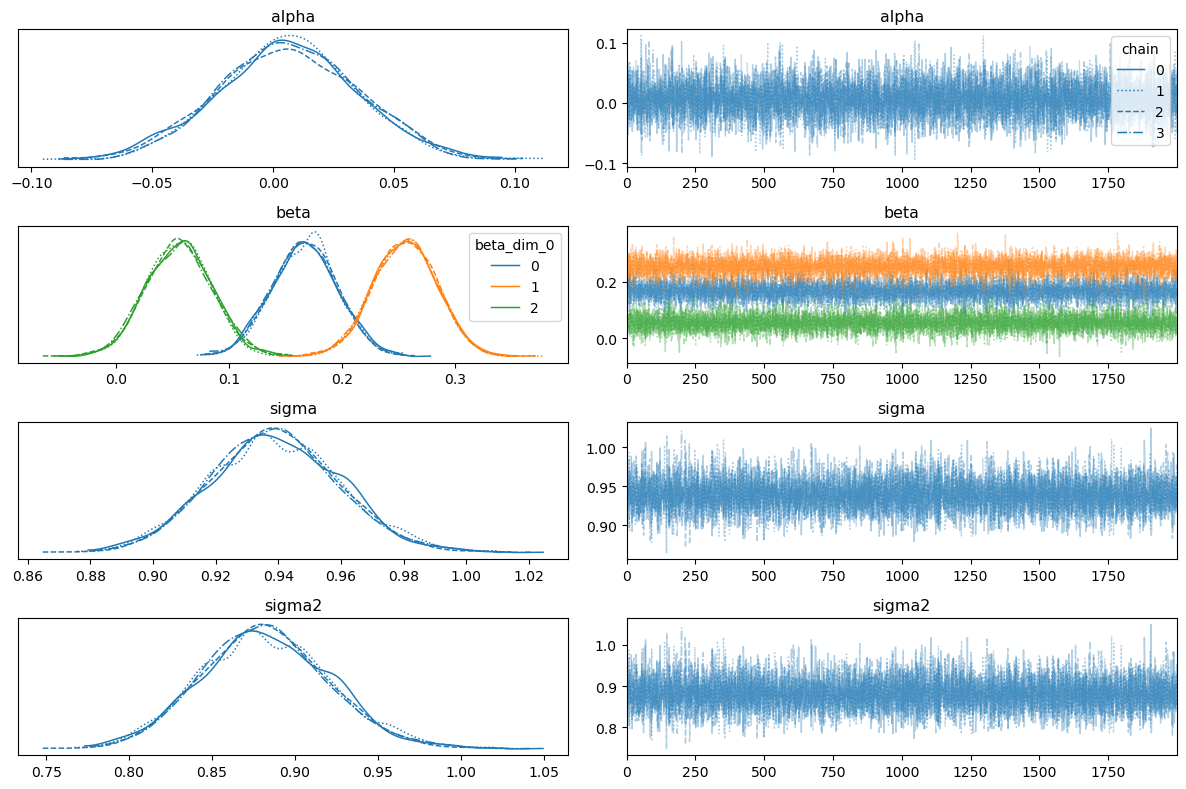

In [ ]:
# Show data graphically
f = az.plot_trace(vectorizedFit, var_names = ['alpha', 'beta', 'sigma', 'sigma2'], figsize = (12, 8), legend = True)
plt.tight_layout()

## Which of the three variables is the best predictor of insurance charges? ##

For this question, it is worth noting that we used the random seed of 42 to keep consistent results for testing purposes.

The table provides the following information for each of the predictors:

BMI (listed as beta[0]):        mean = 0.167, HDI range = (0.115, 0.223), HDI range difference = 0.108

Age (listed as beta[1]):        mean = 0.256, HDI range = (0.205, 0.310), HDI range difference = 0.105

Children (listed as beta[2]):   mean = 0.056, HDI range = (0.003, 0.110), HDI range difference = 0.107

From this data we can see that Age shows the best mean value, as well as the HDI range that is the farthest away from 0. Children and BMI have significantly smaller mean values and HDI ranges which are much closer to 0, showing little to no contest as to which variable is the best preidictor. While it can be argued that HDI range difference matters, each variable is within 0.003 of each other, which is such a minute difference that it would make more sense to look at the large differences between each variable. Thus, we can safely say that Age is the best predictor of Insurance Charges, followed by BMI, and then Children in last.